# FORNAX 3D Neutrino Spectra

Some I/O and plotting using the Fornax 3D models from [Vartanyan, Burrows, et al., MNRAS 482(1):351, 2019](https://arxiv.org/abs/1809.05106), which express the angular dependence of the neutrino luminosity from CCSNe in terms of a spherical harmonic expansion up to degree $\ell=2$.

The data are available on [the Burrows group website](https://www.astro.princeton.edu/~burrows/nu-emissions.3d/).

In [1]:
from snewpy.neutrino import Flavor
from snewpy.models import Fornax_2019_3D

from astropy import units as u

from glob import glob

import h5py
import healpy as hp

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
mpl.rc('font', size=16)

## Test Instantiation using a $10M_{\odot}$ Model

In [3]:
model = Fornax_2019_3D('../../models/Fornax_2019/lum_spec_10M.h5')
model

**Fornax 3D Model**: ../../models/Fornax_2019/lum_spec_10M.h5

|Parameter|Value|
|:---------|:-----:|
|Progenitor mass | $10$ $\mathrm{M_{\odot}}$|

### Time Evolution of the Energy Spectra

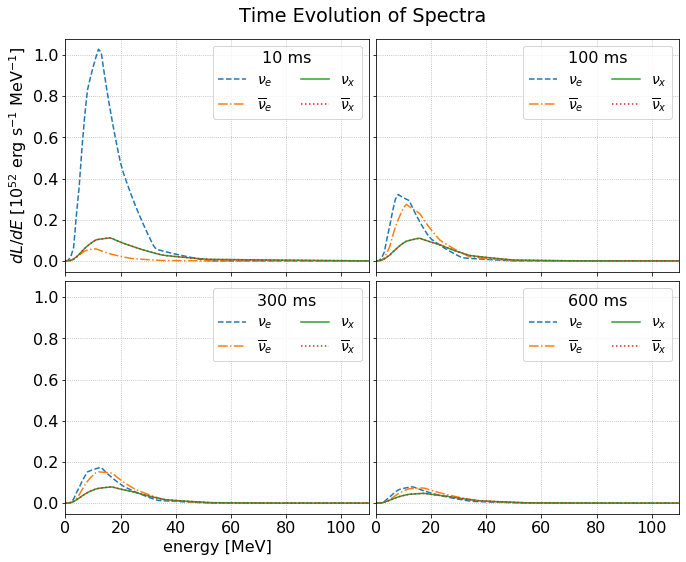

In [20]:
E = np.arange(0,111) * u.MeV
theta = 23.55*u.degree
phi = 22.5*u.degree

fig, axes = plt.subplots(2,2, figsize=(11,8), sharex=True, sharey=True,
                         gridspec_kw = {'hspace':0.04, 'wspace':0.025})
axes = axes.flatten()

for ax, t in zip(axes, [10., 100., 300., 600.]):
    t *= u.ms
    spectra = model.get_initialspectra(t, E, theta, phi)
    
    lines = ['--', '-.', '-', ':']
    for line, flavor in zip(lines, Flavor):
        ax.plot(E, spectra[flavor].to('1e52 erg/(s MeV)'), ls=line, label=flavor.to_tex())
    ax.legend(fontsize=14, ncol=2, loc='upper right', title='{:g}'.format(t))
    ax.set(xlim=(E[0].to_value('MeV'), E[-1].to_value('MeV')))
    ax.grid(ls=':')

axes[0].set(ylabel=r'$dL/dE$ [$10^{52}$ erg s$^{-1}$ MeV$^{-1}$]')
axes[2].set(xlabel=r'energy [MeV]');

fig.suptitle('Time Evolution of Spectra'.format(t))
fig.subplots_adjust(top=0.925, bottom=0.1)

## Test Caching of Full Model Angular Dependence

Here, if the user specifies `cache_flux=True` in the model constructor, the entire angular dependence of the model will be computed using a [HEALPix grid](https://healpy.readthedocs.io/en/latest/) with 192 pixels, using a HEALPix grid with parameter `nside=4` and `ordering=RING`. The model constructor will calculate the CCSN fluxes on the unit sphere at the centers of the 192 healpixels for all energy and time bins in the model.

The resulting tables are then saved to a FITS file in the same location as the input HDF5 file. If the user instantiates this model with `cache_flux=True` in the future, the model will be initialized using the cached FITS file.

Comments:
1. The HDF5 files store the angular dependence of the models in a highly compressed format using the spherical harmonic expansion up to degree $\ell=2$.
2. The time bins are equal across all flavors but the energy binning is a function of both time and flavor.
2. Computing the fluxes at 192 locations on the sky takes about 30 seconds per flavor due to the overhead of reading out the HDF5 files. So construction of the cached model is **slow** when called for the first time.

In [5]:
cmodel = Fornax_2019_3D('../../models/Fornax_2019/lum_spec_10M.h5', cache_flux=True)
cmodel

INFO:root:Caching ../../models/Fornax_2019/lum_spec_10M.h5 for Flavor.NU_E (nu0)
INFO:root:Caching ../../models/Fornax_2019/lum_spec_10M.h5 for Flavor.NU_E_BAR (nu1)
INFO:root:Caching ../../models/Fornax_2019/lum_spec_10M.h5 for Flavor.NU_X (nu2)
INFO:root:Caching ../../models/Fornax_2019/lum_spec_10M.h5 for Flavor.NU_X_BAR (nu2)


**Fornax 3D Model**: ../../models/Fornax_2019/lum_spec_10M.h5

|Parameter|Value|
|:---------|:-----:|
|Progenitor mass | $10$ $\mathrm{M_{\odot}}$|

### Test Equivalence of the Cached and Uncached Models

In [13]:
t = 100 * u.ms

Es, dEs, spectras = model._get_binnedspectra(t, theta, phi)
Ec, dEc, spectrac = cmodel._get_binnedspectra(t, theta, phi)

for flavor in Flavor:
    print('\n{}'.format(str(flavor)))
    print(Es[flavor])
    print(Ec[flavor])
    print(spectras[flavor])
    print(spectrac[flavor])
    
    j = np.argmax(spectrac[flavor])
    print('Max value:')
    print(Ec[flavor][j], spectrac[flavor][j])


Flavor.NU_E
[  1.12409548   1.80813134   2.90841747   4.67825097   7.52506555
  12.10422696  19.46990488  31.31775346  50.37526829  81.02968365
 130.33795859 209.65136088] MeV
[  1.12409548   1.80813134   2.90841747   4.67825097   7.52506555
  12.10422696  19.46990488  31.31775346  50.37526829  81.02968365
 130.33795859 209.65136088] MeV
[1.72536301e+49 7.24984201e+49 3.63895427e+50 1.48246568e+51
 3.26752946e+51 2.92454494e+51 1.11961656e+51 1.47364614e+50
 1.52159412e+47 5.22545606e+42 9.13369778e+40 5.47718112e+39] erg / (MeV s)
[1.72536069e+49 7.24983055e+49 3.63895332e+50 1.48246565e+51
 3.26752613e+51 2.92453992e+51 1.11961449e+51 1.47364243e+50
 1.52159067e+47 5.22687383e+42 9.13386733e+40 5.47710343e+39] erg / (MeV s)
Max value:
7.525065547748337 MeV 3.2675261260733763e+51 erg / (MeV s)

Flavor.NU_E_BAR
[ 1.07379938  1.57612195  2.31343064  3.3956518   4.98413523  7.31571003
 10.73799383 15.76121948 23.13430641 33.956518   49.84135225 73.15710034] MeV
[ 1.07379938  1.57612195 

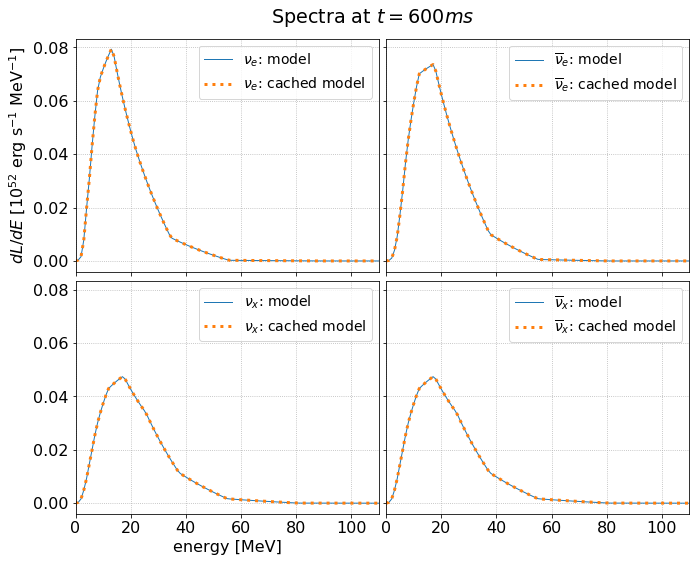

In [21]:
t = 600 * u.ms
E = np.arange(0,111) * u.MeV
theta = 23.55*u.degree
phi = 22.5*u.degree

spectra = model.get_initialspectra(t, E, theta, phi)
cspectra = cmodel.get_initialspectra(t, E, theta, phi)
    
fig, axes = plt.subplots(2,2, figsize=(11,8), sharex=True, sharey=True,
                         gridspec_kw = {'hspace':0.04, 'wspace':0.025})
axes = axes.flatten()

spectra = model.get_initialspectra(t, E, theta, phi)

for ax, flavor in zip(axes, Flavor):
    ax.plot(E, spectra[flavor].to('1e52 erg/(s MeV)'), ls='-', lw=1, label='{}: model'.format(flavor.to_tex()))
    ax.plot(E, spectra[flavor].to('1e52 erg/(s MeV)'), ls=':', lw=3, label='{}: cached model'.format(flavor.to_tex()))
    ax.legend(fontsize=14, ncol=1, loc='upper right')
    
    ax.set(xlim=(E[0].to_value('MeV'), E[-1].to_value('MeV')))
    ax.grid(ls=':')

axes[0].set(ylabel=r'$dL/dE$ [$10^{52}$ erg s$^{-1}$ MeV$^{-1}$]')
axes[2].set(xlabel=r'energy [MeV]')

fig.suptitle('Spectra at $t={{{:g}}}$'.format(t))
fig.subplots_adjust(top=0.925, bottom=0.1)

### Plot $L_\nu(t,\theta,\varphi)$ at Several Times

Plot the angular dependence $L(t)$ for several values of $t$.

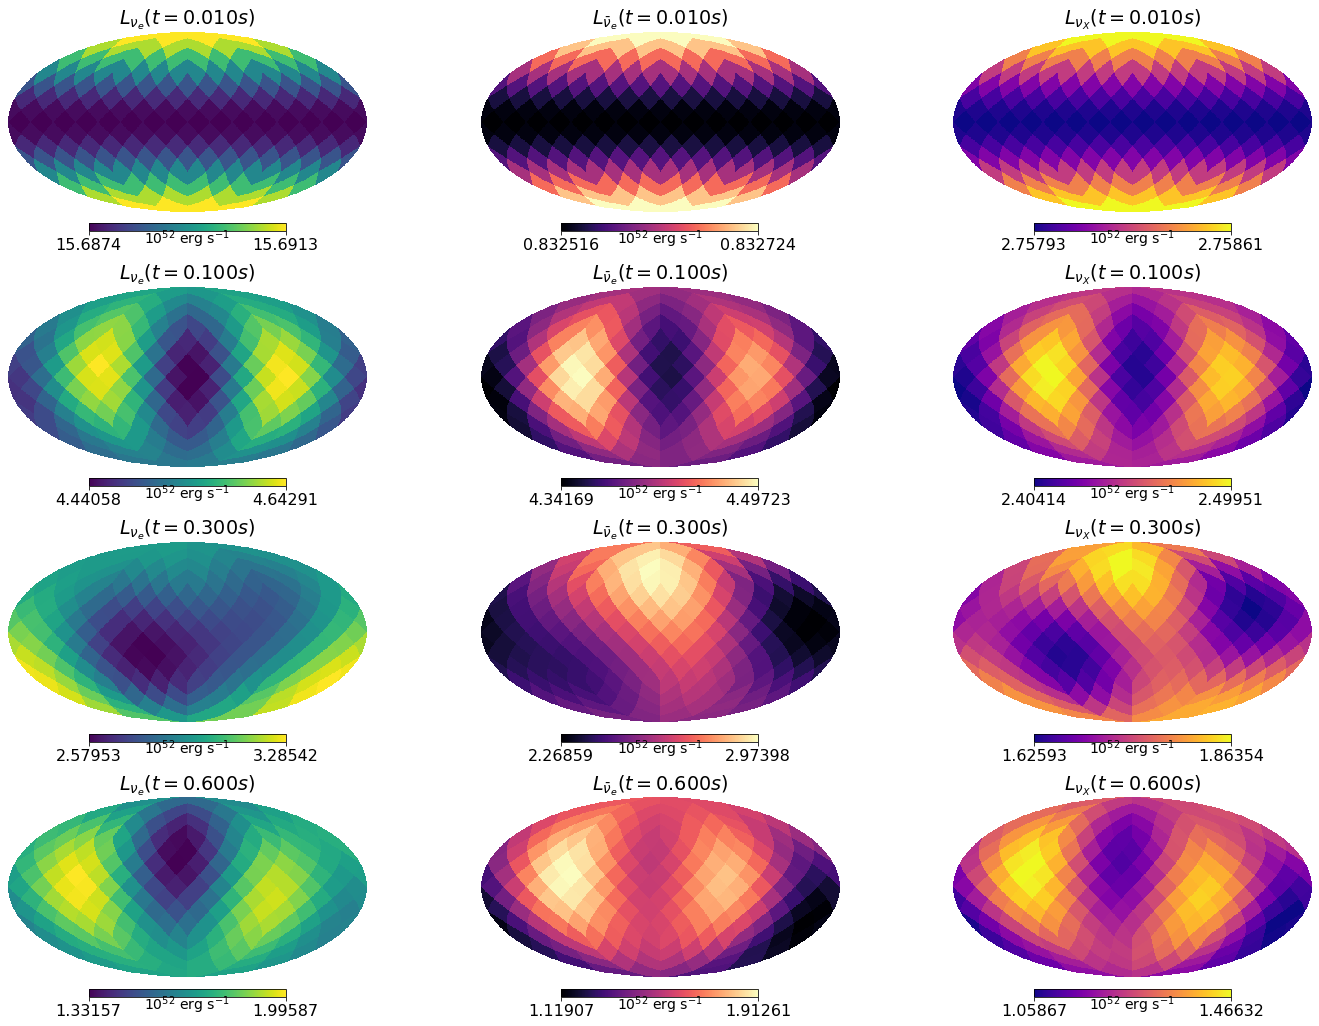

In [30]:
import healpy as hp

times = np.asarray([10., 100., 300., 600.]) * u.ms
nt = len(times)

fig, axes = plt.subplots(nt,3, figsize=(8*3, nt*4.5))

L_nue = cmodel.luminosity[Flavor.NU_E].to('1e52*erg/s')
L_nue_bar = cmodel.luminosity[Flavor.NU_E_BAR].to('1e52*erg/s')
L_nux = cmodel.luminosity[Flavor.NU_X].to('1e52*erg/s')

for i, t in enumerate(times):
    j = (np.abs(t - cmodel.time)).argmin()
    
    ax = axes[i,0]
    plt.axes(ax)
    hp.mollview(L_nue[j], title=r'$L_{{\nu_e}}(t={:.3f})$'.format(cmodel.time[j]),
                unit=r'$10^{52}$ erg s$^{-1}$', cmap='viridis',
                hold=True)
    
    ax = axes[i,1]
    plt.axes(ax)
    hp.mollview(L_nue_bar[j], title=r'$L_{{\bar{{\nu}}_e}}(t={:.3f})$'.format(cmodel.time[j]),
                unit=r'$10^{52}$ erg s$^{-1}$', cmap='magma',
                hold=True)
    
    ax = axes[i,2]
    plt.axes(ax)
    hp.mollview(L_nux[j], title=r'$L_{{\nu_X}}(t={:.3f})$'.format(cmodel.time[j]),
                unit=r'$10^{52}$ erg s$^{-1}$', cmap='plasma',
                hold=True)

### Superimpose $L_\nu(t,\theta,\varphi)$ at All Locations on the Sphere

Plot $L(t)$ at all locations as well as the average, and then the deviation from the average.

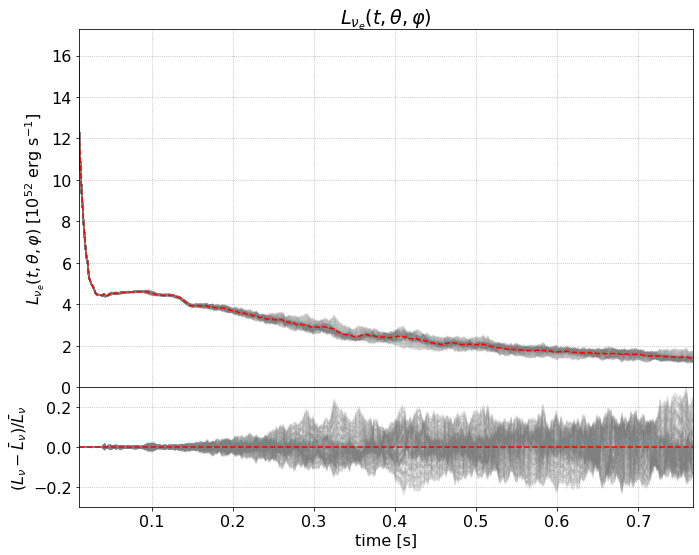

In [8]:
Lavg = np.average(L_nue, axis=1)
dL_over_L = (L_nue - Lavg[:,np.newaxis]) / Lavg[:,np.newaxis]

fig, axes = plt.subplots(2,1, figsize=(10,8),
                         gridspec_kw = {'height_ratios':[3,1], 'hspace':0},
                         sharex=True, tight_layout=True)

ax = axes[0]
ax.plot(cmodel.time, L_nue, color='gray', alpha=0.05)
ax.plot(cmodel.time, Lavg, color='r', ls='--')
ax.set(xlim=cmodel.time[0::len(cmodel.time)-1].value,
       ylabel=r'$L_{\nu_e}(t,\theta,\varphi)$ [$10^{52}$ erg s$^{-1}$]',
       ylim=(0, 1.1*np.max(L_nue).value),
       title=r'$L_{\nu_e}(t,\theta,\varphi)$')
ax.grid(ls=':')

ax = axes[1]
ax.plot(cmodel.time, dL_over_L, color='gray', alpha=0.1)
ax.plot(cmodel.time, np.zeros(cmodel.time.shape), ls='--', color='r')
ax.set(xlabel='time [s]',
       ylabel=r'$(L_\nu - \bar{L}_\nu)/\bar{L}_\nu$',
       ylim=(-0.3, 0.3))
ax.grid(ls=':');

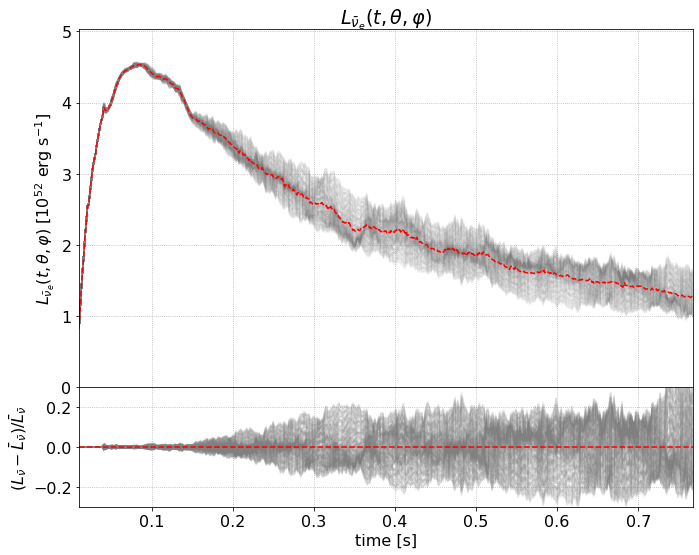

In [31]:
Lavg = np.average(L_nue_bar, axis=1)
dL_over_L = (L_nue_bar - Lavg[:,np.newaxis]) / Lavg[:,np.newaxis]

fig, axes = plt.subplots(2,1, figsize=(10,8),
                         gridspec_kw = {'height_ratios':[3,1], 'hspace':0},
                         sharex=True, tight_layout=True)

ax = axes[0]
ax.plot(cmodel.time, L_nue_bar, color='gray', alpha=0.05)
ax.plot(cmodel.time, Lavg, color='r', ls='--')
ax.set(xlim=cmodel.time[0::len(cmodel.time)-1].value,
       ylabel=r'$L_{\bar{\nu}_e}(t,\theta,\varphi)$ [$10^{52}$ erg s$^{-1}$]',
       ylim=(0, 1.1*np.max(L_nue_bar).value),
       title=r'$L_{\bar{\nu}_e}(t,\theta,\varphi)$')
ax.grid(ls=':')

ax = axes[1]
ax.plot(cmodel.time, dL_over_L, color='gray', alpha=0.1)
ax.plot(cmodel.time, np.zeros(cmodel.time.shape), ls='--', color='r')
ax.set(xlabel='time [s]',
       ylabel=r'$(L_\bar{\nu} - \bar{L}_\bar{\nu})/\bar{L}_\bar{\nu}$',
       ylim=(-0.3, 0.3))
ax.grid(ls=':');

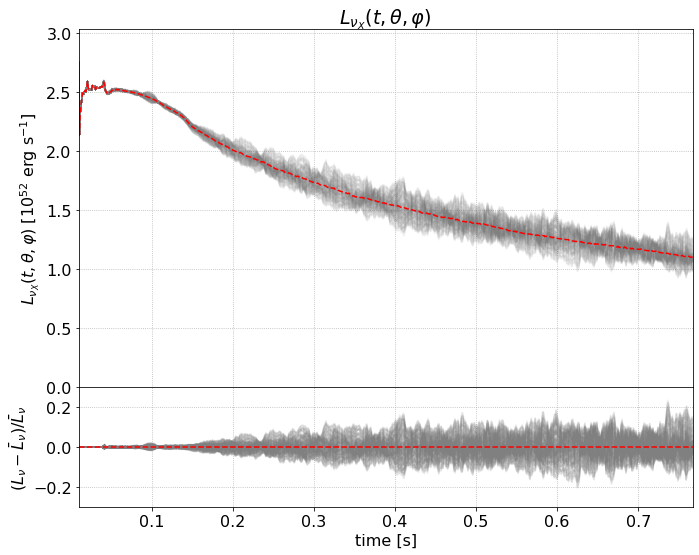

In [32]:
Lavg = np.average(L_nux, axis=1)
dL_over_L = (L_nux - Lavg[:,np.newaxis]) / Lavg[:,np.newaxis]

fig, axes = plt.subplots(2,1, figsize=(10,8),
                         gridspec_kw = {'height_ratios':[3,1], 'hspace':0},
                         sharex=True, tight_layout=True)

ax = axes[0]
ax.plot(cmodel.time, L_nux, color='gray', alpha=0.05)
ax.plot(cmodel.time, Lavg, color='r', ls='--')
ax.set(xlim=cmodel.time[0::len(cmodel.time)-1].value,
       ylabel=r'$L_{\nu_X}(t,\theta,\varphi)$ [$10^{52}$ erg s$^{-1}$]',
       ylim=(0, 1.1*np.max(L_nux).value),
       title=r'$L_{\nu_X}(t,\theta,\varphi)$')
ax.grid(ls=':')

ax = axes[1]
ax.plot(cmodel.time, dL_over_L, color='gray', alpha=0.1)
ax.plot(cmodel.time, np.zeros(cmodel.time.shape), ls='--', color='r')
ax.set(xlabel='time [s]',
       ylabel=r'$(L_\nu - \bar{L}_\nu)/\bar{L}_\nu$',
       ylim=(-0.3, 0.3))
ax.grid(ls=':');